# Stay Subway Safe

## Front End - Interface
To interact with our wireframe (made with JustInMind), click here: https://www.justinmind.com/usernote/tests/47687661/47738106/47746104/index.html

## Backend, with logic explanations

### User input
These variable are defined by user input, as depicted in wireframe.

For this demonstration, values are hard coded and we assume the user wants to know what is happening NOW.

In [1]:
from datetime import datetime
import numpy as np

In [2]:
station = "96 ST"
trainline = "1"
date = datetime.date(datetime.now())
time = datetime.time(datetime.now())

### Gather necessary data to fulfill request

In [3]:
import os
import sys
sys.path.insert(0, os.path.abspath(r'C:\Users\Raayan\Documents\Github\MassTransit'))

In [4]:
from get_station_csv import get_final_station_data
from sort_by_week_day import sort_all_days
from h4_chunks_in_py import entries_exits_in_4h_chunks

We scrape the most recent week's data for this requested station...

In [8]:
get_final_station_data(1, station, trainline)

...then sort that data by day of the week and create individual csv files.

In [9]:
sort_all_days(station)

If the user's requested day is a weekday, the prediction will be based on average crowd size across all weekdays from the previous week during the requested time window. This mitigates the impact of anomolies from the previous week on the prediction. 

If the user requests info for a Saturday or Sunday, we look specifically at the previous Saturday or Sunday. This is because the MTA runs fewer trains on Sundays than other days of the week, and ridership differs significantly on each of these days.

In [10]:
requestedDay = date.weekday()
weekDays = ("Mon","Tue","Wed","Thu","Fri","Sat","Sun")

We use our other modules to get the number of train arrivals and number of turnstile entries per hour.

Train arrivals are specific to the day of the week but not the date. we will get this value now so that we don't have to call it multiple times in the loop below. However, turnstile entries are date specific, so we will call when we need it.

In [11]:
from train_info_from_schedule import single_frequency
from entries_exits import get_entry_exit_given_hour

In [13]:
stops_path = r'C:\Users\Raayan\Documents\Github\MassTransit\google_transit\stop_times.txt'
trips_path = r'C:\Users\Raayan\Documents\Github\MassTransit\google_transit\trips.txt'
stop_id = "120" #HARDCODED for 96th, our pilot

#train schedule is recorded only between 6 am ('06') and 11 pm ('23') to make room for cleaning
#also, time needs to be formatted to have 2 digits
hourINT = time.hour
if (hourINT < 6):
    hour = "06"
elif (hourINT > 23):
    hour = "23"
elif (hourINT < 10):
    hour = "0" + str(hourINT)
else:
    hour = str(hourINT)

#train schedule data is split into weekday, Saturday, Sunday
if(requestedDay <= 4):
    day_type = "Weekday"
elif(requestedDay == 5):
    day_type = "Saturday"
else:
    day_type = "Sunday"



northTrains = single_frequency(stops_path,trips_path,stop_id,hour,day_type,"Northbound")
southTrains = single_frequency(stops_path,trips_path,stop_id,hour,day_type,"Southbound")

trainsPerPlatform = np.array([northTrains, southTrains])
trainsPerPlatform

array([27, 25], dtype=int64)

reformat time as needed to get turnstile entry information

time_input should be in 24 hr hh:mm 

In [14]:
mins = str(time.minute)
if(len(mins) == 1):
    mins = "0" + mins

time_input = hour + ":" + mins

#our turnstile data is available from 06:00 - 20:59
#we already account for 06:00 bound above, we need to now account for 20:59 bound here.
if(hourINT > 20):
    time_input = "20:59"

### The meat and potatoes: The Algorithm

1) totalEntries = get total station entries in that time chunk

2) entriesPerPlatform = totalEntries / # of platforms

3) trainsPerPlatform = a list of the number of trains arriving to each relavent platform in the time window

4) predictedCrowds = entriesPerPlatform / trainsPerPlatform 
    a list of max crowd size for each platform
    
5) return predictedCrowds to interface

This algorithm tells the user how large, on average, crowd size becomes before the train arrives.


96th street has 2 in service island platforms https://en.wikipedia.org/wiki/96th_Street_station_(IRT_Broadway%E2%80%93Seventh_Avenue_Line) 
We hardcode this value for the pilot program

In [15]:
totalEntries = 0
totalExits = 0 #throw-away value
predictedCrowds = np.array([0,0]) #HARDCODED for 96th. 2 platforms, 2 crowd predictions.

if(requestedDay <= 4): #is a work day
    sumCrowds = np.array([0,0]) #HARDCODED for 96
    for i in range (0,5):
        filename = weekDays[i] + ".csv"
        path = r"C:/Users/Raayan/Documents/Github/MassTransit/" + filename
        totalEntries, totalExits = get_entry_exit_given_hour(path,time_input) 
        entriesPerPlatform = totalEntries / 2 #HARDCODED, num. platforms at 96th
        
        tempCrowds = entriesPerPlatform / trainsPerPlatform
        sumCrowds = sumCrowds + tempCrowds

    predictedCrowds = sumCrowds / 5 #avg over 5 work days
         
else: #is weekend
    filename = weekDays[requestedDay] + ".csv"
    path = '/Users/mehrkaur/Documents/projects/subway/MassTransit/' + filename
    totalEntries, totalExits = get_entry_exit_given_hour(path,time_input)
    entriesPerPlatform = totalEntries / 2 #HARDCODED, num. platforms at 96th

    predictedCrowds = entriesPerPlatform / trainsPerPlatform
    

C:\Users\Raayan\Documents\Github\MassTransit\entries_exits.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item['ENTRIES']=entries
C:\Users\Raayan\Documents\Github\MassTransit\entries_exits.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item[item.columns[11]]=exits


In [16]:
print(totalEntries)
print(predictedCrowds)

314.75
[6.00277778 6.483     ]


predictedCrowds is the return value of the algorithm

In [85]:
from datetime import datetime
import numpy as np
import os
import sys
sys.path.insert(0, os.path.abspath(r'C:\Users\Raayan\Documents\Github\MassTransit'))
from get_station_csv import get_final_station_data
from sort_by_week_day import sort_all_days
from h4_chunks_in_py import entries_exits_in_4h_chunks
from train_info_from_schedule import single_frequency
from entries_exits import get_entry_exit_given_hour


#stop_id is 120 for 96th Street, 117 for 116th Street - both on the 1 line
def get_crowds(date,time,stop_id):
    requestedDay = date.weekday()
    weekDays = ("Mon","Tue","Wed","Thu","Fri","Sat","Sun")
    stops_path = r'C:\Users\Raayan\Documents\Github\MassTransit\google_transit\stop_times.txt'
    trips_path = r'C:\Users\Raayan\Documents\Github\MassTransit\google_transit\trips.txt'
    #stop_id = "117" #HARDCODED for 96th, our pilot
    
    #train schedule is recorded only between 6 am ('06') and 11 pm ('23') to make room for cleaning
    #also, time needs to be formatted to have 2 digits
    hourINT = time.hour
    if (hourINT < 6):
        hour = "06"
    elif (hourINT > 23):
        hour = "23"
    elif (hourINT < 10):
        hour = "0" + str(hourINT)
    else:
        hour = str(hourINT)

    #train schedule data is split into weekday, Saturday, Sunday
    if(requestedDay <= 4):
        day_type = "Weekday"
    elif(requestedDay == 5):
        day_type = "Saturday"
    else:
        day_type = "Sunday"

    northTrains = single_frequency(stops_path,trips_path,stop_id,hour,day_type,"Northbound")
    southTrains = single_frequency(stops_path,trips_path,stop_id,hour,day_type,"Southbound")
    trainsPerPlatform = np.array([northTrains, southTrains])
    mins = str(time.minute)
    if(len(mins) == 1):
        mins = "0" + mins

    time_input = hour + ":" + mins

    #our turnstile data is available from 06:00 - 20:59
    #we already account for 06:00 bound above, we need to now account for 20:59 bound here.
    if(hourINT > 20):
        time_input = "20:59"
        
    totalEntries = 0
    totalExits = 0 #throw-away value
    predictedCrowds = np.array([0,0]) #HARDCODED for 96th. 2 platforms, 2 crowd predictions.

    if(requestedDay <= 4): #is a work day
        sumCrowds = np.array([0,0]) #HARDCODED for 96
        for i in range (0,5):
            filename = weekDays[i] + ".csv"
            path = r"C:/Users/Raayan/Documents/Github/MassTransit/" + filename
            totalEntries, totalExits = get_entry_exit_given_hour(path,time_input) 
            entriesPerPlatform = totalEntries / 2 #HARDCODED, num. platforms at 96th

            tempCrowds = entriesPerPlatform / trainsPerPlatform
            sumCrowds = sumCrowds + tempCrowds

        predictedCrowds = sumCrowds / 5 #avg over 5 work days

    else: #is weekend
        filename = weekDays[requestedDay] + ".csv"
        path = r"C:/Users/Raayan/Documents/Github/MassTransit/" + filename
        totalEntries, totalExits = get_entry_exit_given_hour(path,time_input)
        entriesPerPlatform = totalEntries / 2 #HARDCODED, num. platforms at 96th

        predictedCrowds = entriesPerPlatform / trainsPerPlatform
    
    return totalEntries, predictedCrowds

In [54]:
get_final_station_data(1, station, trainline)
sort_all_days(station)

In [61]:
#Weekday 96th
from datetime import time
time1=time(6,0,0)
time_list=[]
time_list.append(time1)
for i in range(1,15):
    time_list.append(time(6+i,0,0))
weekday_crowds=[get_crowds(date,time,'120') for time in time_list]

C:\Users\Raayan\Documents\Github\MassTransit\train_info_from_schedule.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  source['hour_of_day'][item]=source['arrival_time'][item][:2]
C:\Users\Raayan\Documents\Github\MassTransit\entries_exits.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item['ENTRIES']=entries
C:\Users\Raayan\Documents\Github\MassTransit\entries_exits.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

In [60]:
import matplotlib.pyplot as plt
%matplotlib inline

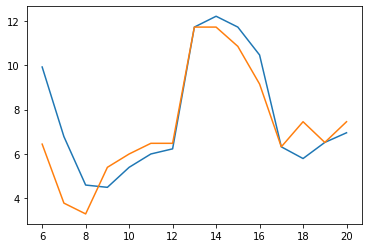

In [78]:
#Weekday forecasts for 96th Street station
entry_forecasts=[]
northbound_forecasts=[]
southbound_forecasts=[]
for item in weekday_crowds:
    entry_forecasts.append(item[0])
    northbound_forecasts.append(item[1][0])
    southbound_forecasts.append(item[1][1])
x_axis=[6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
plt.plot(x_axis,northbound_forecasts)
plt.plot(x_axis,southbound_forecasts)

In [81]:
#Sunday
from datetime import date,time
time1=time(6,0,0)
time_list=[]
time_list.append(time1)
for i in range(1,15):
    time_list.append(time(6+i,0,0))
date=date(2020,7,26)
sunday_crowds=[get_crowds(date,time,'120') for time in time_list]

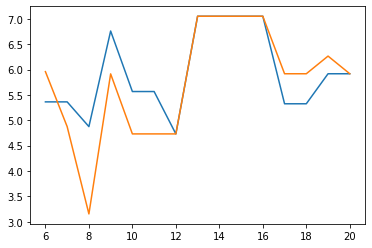

In [82]:
#Sunday forecasts for 96th street station
entry_forecasts=[]
northbound_forecasts=[]
southbound_forecasts=[]
for item in sunday_crowds:
    entry_forecasts.append(item[0])
    northbound_forecasts.append(item[1][0])
    southbound_forecasts.append(item[1][1])
x_axis=[6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
plt.plot(x_axis,northbound_forecasts)
plt.plot(x_axis,southbound_forecasts)

In [83]:
#Saturday
from datetime import date,time
time1=time(6,0,0)
time_list=[]
time_list.append(time1)
for i in range(1,15):
    time_list.append(time(6+i,0,0))
date=date(2020,7,25)
saturday_crowds=[get_crowds(date,time,'120') for time in time_list]

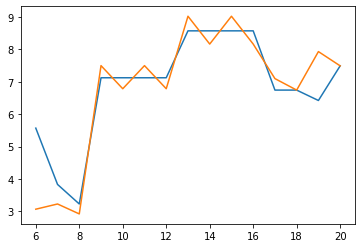

In [84]:
#Saturday forecasts for 96th street station
entry_forecasts=[]
northbound_forecasts=[]
southbound_forecasts=[]
for item in saturday_crowds:
    entry_forecasts.append(item[0])
    northbound_forecasts.append(item[1][0])
    southbound_forecasts.append(item[1][1])
x_axis=[6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
plt.plot(x_axis,northbound_forecasts)
plt.plot(x_axis,southbound_forecasts)

In [91]:
get_final_station_data(1, '116 ST-COLUMBIA', '1')
sort_all_days('116 ST-COLUMBIA')

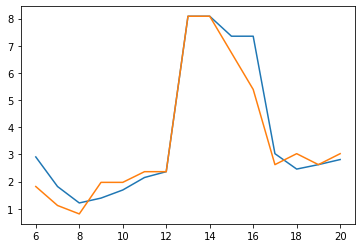

In [92]:
#Weekday, 116th Street
from datetime import date,time
time1=time(6,0,0)
time_list=[]
time_list.append(time1)
for i in range(1,15):
    time_list.append(time(6+i,0,0))
date=datetime.date(datetime.now())
weekday_crowds=[get_crowds(date,time,'117') for time in time_list]
#Weekday for 116th street station
entry_forecasts=[]
northbound_forecasts=[]
southbound_forecasts=[]
for item in weekday_crowds:
    entry_forecasts.append(item[0])
    northbound_forecasts.append(item[1][0])
    southbound_forecasts.append(item[1][1])
x_axis=[6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
plt.plot(x_axis,northbound_forecasts)
plt.plot(x_axis,southbound_forecasts)

In [ ]:
#Sunday, 116th Street
from datetime import date,time
time1=time(6,0,0)
time_list=[]
time_list.append(time1)
for i in range(1,15):
    time_list.append(time(6+i,0,0))
date=date(2020,7,26)
sunday_crowds=[get_crowds(date,time,'117') for time in time_list]
#Weekday for 116th street station
entry_forecasts=[]
northbound_forecasts=[]
southbound_forecasts=[]
for item in sunday_crowds:
    entry_forecasts.append(item[0])
    northbound_forecasts.append(item[1][0])
    southbound_forecasts.append(item[1][1])
x_axis=[6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
plt.plot(x_axis,northbound_forecasts)
plt.plot(x_axis,southbound_forecasts)

In [ ]:
#Saturday, 116th Street
from datetime import date,time
time1=time(6,0,0)
time_list=[]
time_list.append(time1)
for i in range(1,15):
    time_list.append(time(6+i,0,0))
date=date(2020,7,25)
sunday_crowds=[get_crowds(date,time,'117') for time in time_list]
#Weekday for 116th street station
entry_forecasts=[]
northbound_forecasts=[]
southbound_forecasts=[]
for item in saturday_crowds:
    entry_forecasts.append(item[0])
    northbound_forecasts.append(item[1][0])
    southbound_forecasts.append(item[1][1])
x_axis=[6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
plt.plot(x_axis,northbound_forecasts)
plt.plot(x_axis,southbound_forecasts)

### Grader
Color codes the returned crowd size depending on the size of the selected platforms.

In [14]:
#in progress - Andrew
platformDensities = np.array([0,0])
platform_length = 510
platform_width = 12.5
platform_size = platform_length * platform_width
if predictedCrowds:
    length = len(predictedCrowds)
    platformDensities = np.array(length)
    for i in length:
        if predictedCrowds[i]: density = predictedCrowds[i] / platform_size
        else: density = 0
        platformDensities[i] = density
else: platformDensities = predictedCrowds

platformGrades = np.array(["",""])
green = 0.05
yellow = 0.1
orange = 0.25
if platformDensities:
    length = len(platformDensities)
    platformGrades = np.array(length)
    for i in length:
        if platformDensities[i]:
            if (platformDensities[i] < green): platformGrades[i] = "G"
            elif (platformDensities[i] >= green):
                if (platformDensities[i] >= orange): platformGrades[i] = "R"
                elif (platformDensities[i] < orange): platformGrades[i] = "Y"
                else: platformGrades[i] = "O"
        else: platformGrades[i] = ""
else: platformGrades = np.array(["",""])

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

### Vizualization

add the heat map stuff here, including the "over the course of the day" visual raayan mentioned